# Synthetic Text Generation

In this notebook, we demonstrate how to synthesize free text columns, and will furthermore explore its quality.

For further background see also [this blog post](https://mostly.ai/blog/synthetic-data-for-text-annotation/) on "How To Scale Up Your Text Annotation Initiatives with Synthetic Text". We will be using a trimmed down version of a dataset containing AirBnB listings in London. This dataset can be downloaded in our public data repository [here](https://github.com/mostly-ai/public-demo-data/raw/dev/airbnb/london.csv.gz). The original data was downloaded from [Inside AirBnB](http://insideairbnb.com/get-the-data).

## Synthesize Data via MOSTLY AI

Please make sure to replace 'YOUR_API_KEY' with your actual API Key before running the code below.

In [1]:
from mostlyai import MostlyAI
import pandas as pd

# initialize client
mostly = MostlyAI(api_key='YOUR_API_KEY')

# fetch original data
tgt = pd.read_csv('https://github.com/mostly-ai/public-demo-data/raw/dev/airbnb/london.csv.gz')
print(f"Read original data with {tgt.shape[0]:,} records and {tgt.shape[1]:,} attributes")
tgt

Read original data with 71,938 records and 6 attributes


,host_name,title,property_type,room_type,neighbourhood,price
0,Alina,Holiday London DB Room Let-on going,Private room in rental unit,Private room,Islington,79
1,Philippa,Bright Chelsea Apartment. Chelsea!,Entire rental unit,Entire home/apt,Kensington and Chelsea,75
2,Elinor,Nice double bedroom in NW London,Entire rental unit,Entire home/apt,Camden,229
3,Ingrid,The Residential Suite Above Gallery,Entire rental unit,Entire home/apt,Hackney,132
4,Agri & Roger,You Will Save Money Here,Private room in home,Private room,Barnet,65
...,...,...,...,...,...,...
71933,Terry,Family escape / 6 adults. London,Entire home,Entire home/apt,Croydon,160
71934,Varun,Short stay in north-west London,Private room in rental unit,Private room,Harrow,59
71935,Santosh,Private room in Stratford,Private room in rental unit,Private room,Newham,36
71936,Emily,Fantastic 2bed Flat with Private Roof Terrace,Entire rental unit,Entire home/apt,Westminster,272


In [2]:
# Train a generator on the pre-processed AirBnB data
config = {
    'name': 'Synthetic Text Tutorial AirBnB',
    'tables': [{
        'name': 'airBnB', 'data': tgt,
        'modelConfiguration': {'maxTrainingTime': 10},
        'textModelConfiguration': {'maxTrainingTime': 10},
        'columns': [
            {'name': 'host_name', 'included': True, 'modelEncodingType': 'CATEGORICAL'},
            {'name': 'title', 'included': True, 'modelEncodingType': 'TEXT_MODEL'},
            {'name': 'property_type', 'included': True, 'modelEncodingType': 'CATEGORICAL'},
            {'name': 'room_type', 'included': True, 'modelEncodingType': 'CATEGORICAL'},
            {'name': 'neighbourhood', 'included': True, 'modelEncodingType': 'CATEGORICAL'},
            {'name': 'price', 'included': True, 'modelEncodingType': 'NUMERIC_AUTO'}
        ]
    }]
}

g_airbnb = mostly.train(config=config)

# generate a synthetic dataset
sd = mostly.generate(generator=g_airbnb)
 
# start using it
syn = sd.data()
print(f"Created synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

Created generator ]8;id=750904;https://app.mostly.ai/d/generators/9f9c80c5-cb44-4cad-af5a-a326f3e0ed67\9f9c80c5-cb44-4cad-af5a-a326f3e0ed67]8;;\

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Share it so others can do the same.

Created synthetic dataset ]8;id=76577;https://app.mostly.ai/d/synthetic-datasets/94e4001f-9128-4e69-8d41-37d261887a0f\94e4001f-9128-4e69-8d41-37d261887a0f]8;;\ with generator ]8;id=333439;https://app.mostly.ai/d/generators/9f9c80c5-cb44-4cad-af5a-a326f3e0ed67\9f9c80c5-cb44-4cad-af5a-a326f3e0ed67]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Share it so others can do the same.

Created synthetic data with 71,938 records and 6 attributes


## Explore Synthetic Text

Show 10 randomly sampled synthetic records. Note, that you can execute the following cell multiple times, to see different samples.

In [3]:
syn.sample(n=10)

,host_name,title,property_type,room_type,neighbourhood,price
38495,Eduardo,Master double room in shared entire flat,Private room in rental unit,Private room,Tower Hamlets,32
41866,Jaymin,Luxurious Room In London,Private room in home,Private room,Bromley,78
55918,Muhammad,London interior Apartment,Entire condo,Entire home/apt,Camden,267
47567,James,"Beautiful Studio, Two bedroom and garden",Entire rental unit,Entire home/apt,Waltham Forest,95
41925,_RARE_,Lovely entire rental near Twickenham station,Private room in condo,Private room,Richmond upon Thames,110
60158,_RARE_,Room in beautiful Victorian house for shortler,Private room in home,Private room,Lambeth,24
53155,Kathrin,Pretty flat in Hackney with extra balcony,Entire rental unit,Entire home/apt,Hackney,256
70805,Liz,Apartment One with 5 minutes from station,Private room in rental unit,Private room,Wandsworth,75
71052,_RARE_,Private Room in Richmond,Private room in home,Private room,Richmond upon Thames,71
27862,Luana,"Quirky private, Hackney West - modern flat wit...",Private room in rental unit,Private room,Waltham Forest,60


Compare this to 10 randomly sampled original records.

In [4]:
tgt.sample(n=10)

,host_name,title,property_type,room_type,neighbourhood,price
61966,Conan,Beautiful double bedroom and private bathroom,Private room in condo,Private room,Southwark,70
28574,Adam Umar,Quiet & Clean King Bed in Central London,Private room in rental unit,Private room,Camden,60
49856,Joy,"King size room+ensuite, private gated free par...",Private room in condo,Private room,Tower Hamlets,66
12896,Denis,Cosy 2 bedroom flat with private bathroom quiet,Entire rental unit,Entire home/apt,Enfield,89
38257,Altido,Lovely studio flat w/ terrace in Southeast London,Entire rental unit,Entire home/apt,Lewisham,144
33617,Paul & Chris,Gorgeous Double Room-Walk to Wimbledon Tennis,Private room in condo,Private room,Wandsworth,77
56385,Jasir,"Single bed flat with 3C’s: Cheap, Clean and Cozy!",Entire condo,Entire home/apt,Southwark,185
52455,Caitlin,Modern 1 bedroom flat with secluded garden,Entire condo,Entire home/apt,Waltham Forest,70
63528,Kayode,TMS Cosy 2 bedroom house! Dagenham! Free parking,Entire home,Entire home/apt,Barking and Dagenham,150
66864,Olga,Beautiful 1-bed flat in New Cross/Deptford,Entire condo,Entire home/apt,Lewisham,111


### Inspect Character Set

You will note, that the character set of the synthetic data is shorter. This is due to the privacy mechanism within the MOSTLY AI platform, where very rare tokens are being removed, to prevent that their presence give away information on the existence of individual records.

In [5]:
# Concatenate 'title' strings and remove duplicates by converting to a set, then back to a list
tgt_chars = ''.join(sorted(list(set(tgt['title'].str.cat(sep=' ')))))
syn_chars = ''.join(sorted(list(set(syn['title'].str.cat(sep=' ')))))

# Display the concatenated strings and their lengths
print('## ORIGINAL ##\n', tgt_chars, '\n')
print('Length of ORIGINAL characters:', len(tgt_chars), '\n')
print('## SYNTHETIC ##\n', syn_chars, '\n')
print('Length of SYNTHETIC characters:', len(syn_chars), '\n')

## ORIGINAL ##
  !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ £¦¬®°²´·ÁÉÜàáâãäåçèéìíóôöùüİıœАБВГДЛНРСУабвгдежзийклмнопрстухцшыьюяבדהוחילםמןנעפצקרשתდღ ​‍–—‘’“”•…⁂⁉⁎₂₄₆₈™↑→│▶◀●◑☀☃★☆☑☝☯☸☺☻☼♂♔♕♖♗♚♛♜♝♞♟♡♥♦♪♫♬⚜⚡✅✈✔✦✧✨✩✪✭✮✯✰✵✹✽✾✿❀❁❃❄❆❖❣❤❥❦➊➋➍➔➕➡⟮⟯⬆⭐⭑、。』【】〔〕きなのイキスバムルレ・ー一三世东两中临主之乡二五亚交亮人他付们价伦位住你佳便個倫值備僅入全公共其净出分利别剩务包区區十华单南卧卫厅厨双受可台合和品啦四回园国國在地场型堡塔墅多大天套奢女好威子字学宅安实客室宮家宽宿密寓寧専小尔层居屋市希带帶常干年床店廁建异式德心念思性惠感我或房手抢拎招排政敞敦整文斯新方日明星是晶暑暖最月有服朝期本机极林格档桥梅梯極楼欢歐比民水河治沿洁洗洲济浴海清温源溫滨独王理生用电畔留白的短碼私租立站筑精素紧絕絲级线经维罗置联肯至舍舒英華萨融西觉計設語让象豪贝质超跨車转辦迎近适通速適還邻配酒金鐵钟长間间限院陽雀露静靜非頭馨高齊간개고공교근기깔깨끔끗뉴늑는단담더던독드든락랏럭런렛룸리멋몰베보브블빛살서셔소숙실아안역욕의이인잘장존진처캠크통트파편플하한햇화️﹢！（），［］ｘ～￼𝗕𝗥𝗦𝗮𝗱𝗲𝗴𝗵𝗶𝗹𝗻𝗼𝗿𝘀𝘁𝘂𝘃𝘄𝘆𝟯🅿🇦🇧🇪🇫🇬🇮🇷🇸🇺🌃🌆🌇🌈🌞🌟🌠🌱🌲🌳🌴🌵🌸🌹🌺🌻🌿🍃🍒🎀🎬🎯🎾🏆🏒🏘🏙🏛🏟🏠🏡🏳🏴🏻🏼🐈🐱🐶👌👍👑👥💂💎💐💕💖💗💙💚💛💜💤💫📍📶🔝🖼😊😍😴🙆🚀🚂🚆🚉🚊🚌🚍🚗🚞🚨🚲🛀🛋🛌🛍🛏🤩🤴🥇🥰🧡🪴󠁢󠁥󠁧󠁮󠁿 

Length of ORIGINAL characters: 752 

## SYNTHETIC ##
  !"#$%&'()*+,-./0123456789:;<>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_abcdefghijklmnopqrstuvwxyz{|~ £¦¬®°²´·ÁÜàáâãäåçèéìíóöİıœАВДЛРУавгдеийлмнортуяמןღ‍–—‘’“”•…→│▶◀◑☀★☆☝☯☸☺☻☼♂♕♖♚♛♜♝♟♡

### Inspect Character Frequency

In [6]:
# Get character frequencies for 'tgt'
tgt_chars = tgt['title'].str.split('').explode()
tgt_freq = tgt_chars.value_counts(normalize=True).rename_axis('char').reset_index(name='tgt')

# Get character frequencies for 'syn'
syn_chars = syn['title'].str.split('').explode()
syn_freq = syn_chars.value_counts(normalize=True).rename_axis('char').reset_index(name='syn')

# Merge the frequencies and sort
title_char_freq = pd.merge(tgt_freq, syn_freq, on='char', how='outer').round(5)
title_char_freq.sort_values(by='tgt', ascending=False, inplace=True)

# Display the frequencies
title_char_freq.head(10)

,char,tgt,syn
1,,0.13409,0.13468
80,o,0.07679,0.07795
70,e,0.07653,0.07719
79,n,0.05957,0.05950
85,t,0.05645,0.05756
66,a,0.05333,0.05576
83,r,0.05044,0.05163
0,,0.04836,0.04757
74,i,0.04755,0.04786
77,l,0.03462,0.03542


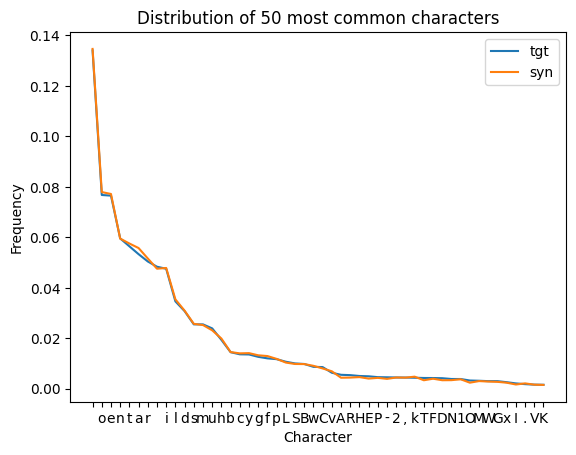

In [7]:
import matplotlib.pyplot as plt

# Set 'char' column as the index
title_char_freq_indexed = title_char_freq.set_index('char')

# Plot the first 50 characters using the new index
ax = title_char_freq_indexed.head(50).plot.line()
plt.title('Distribution of 50 most common characters')

# Set x-axis labels with no rotation for better readability
plt.xticks(ticks=range(len(title_char_freq_indexed.head(50))), labels=title_char_freq_indexed.head(50).index, rotation=0)

plt.xlabel('Character')
plt.ylabel('Frequency')

plt.show()

We can see that Character Frequencies are perfectly retained.

### Inspect Term Frequency

In [9]:
import pandas as pd

def sanitize(s):
    s = str(s).lower()
    s = re.sub('[\\,\\.\\)\\(\\!\\"\\:\\/]', ' ', s)
    s = re.sub('[ ]+', ' ', s)
    return s

# Apply the sanitize function and split the titles into terms
tgt['terms'] = tgt['title'].apply(lambda x: sanitize(x)).str.split(' ')
syn['terms'] = syn['title'].apply(lambda x: sanitize(x)).str.split(' ')

# Explode 'terms' and create a DataFrame with explicit column names before applying value_counts
tgt_terms_df = tgt['terms'].explode().to_frame(name='term')
syn_terms_df = syn['terms'].explode().to_frame(name='term')

# Calculate the normalized value counts and reset the index
tgt_freq = tgt_terms_df['term'].value_counts(normalize=True).reset_index(name='tgt').rename(columns={'index': 'term'})
syn_freq = syn_terms_df['term'].value_counts(normalize=True).reset_index(name='syn').rename(columns={'index': 'term'})

# Merge the frequencies and sort by 'tgt' in descending order
title_term_freq = pd.merge(tgt_freq, syn_freq, on='term', how='outer').round(5)
title_term_freq = title_term_freq.sort_values(by='tgt', ascending=False)

# Display the top and bottom rows
display(title_term_freq.head(10))
display(title_term_freq.head(200).tail(10))

,term,tgt,syn
17349,in,0.05441,0.05094
13798,flat,0.03362,0.03702
26530,room,0.03209,0.03298
19656,london,0.02844,0.02633
6458,bedroom,0.02788,0.02934
4927,apartment,0.02130,0.01852
11721,double,0.02063,0.01724
33913,with,0.01868,0.01875
1971,2,0.01759,0.01793
6356,bed,0.01642,0.01736


,term,tgt,syn
31830,twin,0.00070,0.00045
2446,2br,0.00070,0.00076
32100,unique,0.00069,0.00046
8265,canal,0.00068,0.00091
28460,soho,0.00068,0.00054
13012,excel,0.00067,0.00047
26028,rent,0.00067,0.00038
21045,mews,0.00067,0.00067
10319,cottage,0.00067,0.00061
18960,leafy,0.00067,0.00074


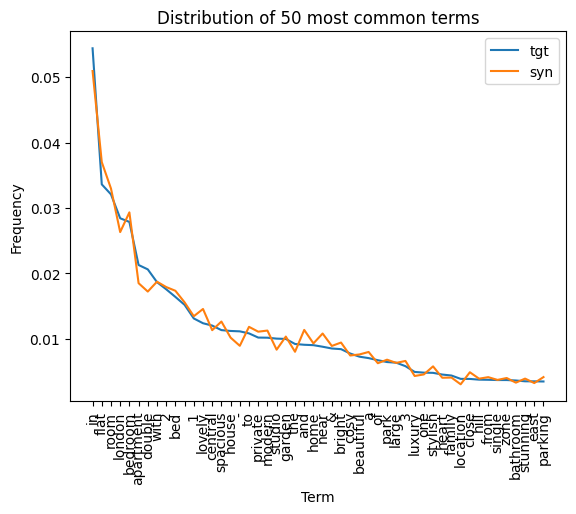

In [10]:
# Set 'term' column as the index
title_term_freq_indexed = title_term_freq.set_index('term')

# Plot the first 50 terms using the new index
ax = title_term_freq_indexed.head(50).plot.line()
plt.title('Distribution of 50 most common terms')

# Set x-axis labels with a 90-degree rotation for better readability
plt.xticks(ticks=range(len(title_term_freq_indexed.head(50))), labels=title_term_freq_indexed.head(50).index, rotation=90)

plt.xlabel('Term')
plt.ylabel('Frequency')

plt.show()

We can see that Term Frequencies are perfectly retained.

### Inspect Term Co-occurrence

In [11]:
def calc_conditional_probability(term1, term2):
    # Ensure no NaN values in 'title' before applying str.contains
    tgt_beds = tgt['title'].fillna('').str.lower().str.contains(term1)
    syn_beds = syn['title'].fillna('').str.lower().str.contains(term1)
    
    # Use the boolean Series to filter 'title' containing term1 and then check for term2
    tgt_beds_double = tgt['title'][tgt_beds].str.lower().str.contains(term2).mean()
    syn_beds_double = syn['title'][syn_beds].str.lower().str.contains(term2).mean()
    
    print(f"{tgt_beds_double:.0%} of original Listings, that contain `{term1}`, also contain `{term2}`")
    print(f"{syn_beds_double:.0%} of synthetic Listings, that contain `{term1}`, also contain `{term2}`")
    print("")

calc_conditional_probability('bed', 'double')
calc_conditional_probability('bed', 'king')
calc_conditional_probability('heart', 'london')
calc_conditional_probability('london', 'heart')

14% of original Listings, that contain `bed`, also contain `double`
10% of synthetic Listings, that contain `bed`, also contain `double`

7% of original Listings, that contain `bed`, also contain `king`
7% of synthetic Listings, that contain `bed`, also contain `king`

28% of original Listings, that contain `heart`, also contain `london`
24% of synthetic Listings, that contain `heart`, also contain `london`

4% of original Listings, that contain `london`, also contain `heart`
4% of synthetic Listings, that contain `london`, also contain `heart`



We can see that Term Co-occurrences are almost perfectly retained.

Now you might be asking yourself: if all of these characteristics are maintained, what are the chances that we'll end up with exact matches, i.e. synthetic records with the exact same `title` value as a record in the original dataset? Or even a synthetic record with the exact same values for all the columns?

Let's start by trying to find an exact match for 1 specific synthetic `title` value:

In [12]:
# find exact match for 1 specific synthetic title value. Copy a `title` value from a synthetic record into the `title_value` field below and run the cell to find an exact match in the original dataset
title_value = "Airy large double room"
tgt.loc[tgt['title'].str.contains(title_value, case=False, na=False)]

,host_name,title,property_type,room_type,neighbourhood,price,terms
4982,Jay,A light and airy large double room.,Private room in home,Private room,Haringey,80,"[a, light, and, airy, large, double, room, ]"


Depending on your chosen value, you may or may not find an exact match. This row-by-row validation process doesn't indicate very much and, more importantly, doesn't scale very well to the 71K rows in the dataset.

### Inspect Privacy via Exact Matches

Let's perform a simplified check for privacy, by looking for exact matches between the synthetic and the original.

For that we first split the original data into two equally-sized sets, and measure the number of matches between those two sets.

In [13]:
n = int(tgt.shape[0]/2)
pd.merge(tgt[['title']][:n].drop_duplicates(), tgt[['title']][n:].drop_duplicates())

,title
0,Cozy double room
1,Single room
2,Double room
3,Bright double room
4,Double Room in Victorian Terrace
...,...
318,"Euston Square Hotel, Superior Double Room (2DX)"
319,"Furnished Flat in Central London, Edgware Road..."
320,Double room to rent
321,"Prime area, professional cleaning, high speed ..."


Next, we take an equally-sized subset of the synthetic data, and again measure the number of matches between that set and the original data.

In [14]:
pd.merge(tgt[['title']][:n].drop_duplicates(), syn[['title']][:n].drop_duplicates())

,title
0,Single bedroom
1,Single room
2,Double room
3,Bright double room
4,3-bedroom house
...,...
223,Single room in East London
224,Private double room with private bathroom
225,Double room to rent
226,Lovely Double Room


We can see that exact matches between original and synthetic data can occur. However, they occur only for the most commonly used descriptions, and they do not occur more often than they occur in the original data itself.

Thus, it's important to note, that matchinig values or matching complete records are by themselves not a sign of privacy leak. They are only an issue if they occur more frequently than we would expect based on the original dataset. Also note that removing those exact matches via post-processing would have a detrimental contrary effect. The absence of a value like "Lovely single room" in a sufficiently large synthetic text corpus would in this case actually give away the fact that this sentence was present in the original. See [[1](#refs)] respectively [[2](#refs)] for more background info on this aspect.

### Analyze Price vs. Text correlation

In [15]:
tgt_term_price = tgt[['terms', 'price']].explode(column='terms').groupby('terms')['price'].median()
syn_term_price = syn[['terms', 'price']].explode(column='terms').groupby('terms')['price'].median()
def print_term_price(term):
    print(f"Median Price of original Listings, that contain `{term}`: ${tgt_term_price[term]:.0f}")
    print(f"Median Price of synthetic Listings, that contain `{term}`: ${syn_term_price[term]:.0f}")
    print("")

print_term_price("luxury")
print_term_price("stylish")
print_term_price("cozy")
print_term_price("small")

Median Price of original Listings, that contain `luxury`: $180
Median Price of synthetic Listings, that contain `luxury`: $175

Median Price of original Listings, that contain `stylish`: $134
Median Price of synthetic Listings, that contain `stylish`: $128

Median Price of original Listings, that contain `cozy`: $70
Median Price of synthetic Listings, that contain `cozy`: $75

Median Price of original Listings, that contain `small`: $55
Median Price of synthetic Listings, that contain `small`: $58



We can see that correlations between Term occurence and the price per night, are also very well retained.

## Conclusion

This tutorial demonstrated how synthetic text can be generated wihtin the context of an otherwise structured dataset. We analyzed the generated texts, and validated that characters and terms occur with the same frequency, while exact matches do not occur anymore likely than within the actual text itself.

This feature thus allows to retain valuable statistical insights, typically burried away in free text columns, that remain inaccessible due to their privacy sensitive nature.

## Further exercises

In addition to walking through the above instructions, we suggest..
* analyzing further correlations, also for `host_name`
* using a different generation mood, eg. conservative sampling
* using a different dataset, eg. the Austrian First Name [[3](#refs)]

## References<a class="anchor" name="refs"></a>

1. https://github.com/mostly-ai/public-demo-data/blob/dev/firstnames_at/firstnames_at.csv.gz
1. https://www.frontiersin.org/articles/10.3389/fdata.2021.679939/full
1. https://mostly.ai/blog/truly-anonymous-synthetic-data-legal-definitions-part-ii/